# Dogs vs cats

In [1]:
import utils

import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical

Using Theano backend.
Using gpu device 0: GeForce GTX 850M (CNMeM is disabled, cuDNN 5105)
/home/ursa/lib/anaconda2/envs/cv/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
PATH = 'data/'

In [3]:
utils.move_validset_into_trainset(PATH, verbose=True)

1000	cat
1000	dog


In [4]:
split_valid = 0.1
utils.generate_validation_set(PATH, val_split=split_valid, verbose=True)

1000/10000		cat
1000/10000		dog


In [5]:
img_shape = (3,224,224)

# Data Augmentation

In [6]:
rotation = 180
width_shift = 0.2
height_shift = 0.2
vertical_flip = True
horizontal_flip = True
vgg_batch_size = 10

#datagen = ImageDataGenerator(
#    rotation_range=rotation,
#    width_shift_range=width_shift,
#    height_shift_range=height_shift,
#    vertical_flip=vertical_flip,
#    horizontal_flip=horizontal_flip
#)

datagen = ImageDataGenerator()

In [7]:
batches_train = datagen.flow_from_directory(
    PATH+'train',
    target_size=(img_shape[1], img_shape[2]),
    class_mode='categorical',
    shuffle=False,
    batch_size=vgg_batch_size
)

batches_valid = datagen.flow_from_directory(
    PATH+'valid',
    target_size=(img_shape[1], img_shape[2]),
    class_mode='categorical',
    shuffle=False,
    batch_size=vgg_batch_size
)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# VGG Model

In [8]:
vgg = Sequential()

vgg.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
vgg.add(Convolution2D(64, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(64, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(128, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(128, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(256, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(256, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(256, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(Flatten())
vgg.add(Dense(4096, activation='relu'))
vgg.add(BatchNormalization())
vgg.add(Dropout(0.5))
vgg.add(Dense(4096, activation='relu'))
vgg.add(BatchNormalization())
vgg.add(Dropout(0.5))
vgg.add(Dense(1000, activation='softmax'))

Load VGG16 weights
http://www.platform.ai/models/vgg16_bn.h5

In [9]:
vgg.load_weights('data/model/vgg16_bn.h5')

In [10]:
vgg_preds_train = vgg.predict_generator(
    batches_train,
    batches_train.nb_sample
)
vgg_preds_valid = vgg.predict_generator(
    batches_valid,
    batches_valid.nb_sample
)

# Model

In [11]:
batch_size = 4
nb_epoch = 5

In [12]:
model = Sequential()


In [13]:
model.add(Dense(2, activation='softmax', input_shape=(1000,)))

In [14]:
model.compile(
    RMSprop(lr=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.fit(
    vgg_preds_train,
    to_categorical(batches_train.classes, 2),
    nb_epoch=nb_epoch,
    batch_size=batch_size,
    validation_data=(
        vgg_preds_valid,
        to_categorical(batches_valid.classes, 2)
    )
)

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 33s - loss: 0.2737 - acc: 0.9396 - val_loss: 0.3734 - val_acc: 0.9380
Epoch 2/5
18000/18000 [==============================] - 23s - loss: 0.3745 - acc: 0.9437 - val_loss: 0.4586 - val_acc: 0.9405
Epoch 3/5
18000/18000 [==============================] - 17s - loss: 0.4320 - acc: 0.9436 - val_loss: 0.5077 - val_acc: 0.9390
Epoch 4/5
18000/18000 [==============================] - 9s - loss: 0.4744 - acc: 0.9453 - val_loss: 0.5647 - val_acc: 0.9385
Epoch 5/5
18000/18000 [==============================] - 6s - loss: 0.5109 - acc: 0.9457 - val_loss: 0.6130 - val_acc: 0.9400


# Save weights

In [16]:
model.save_weights('data/model/dogs_vs_cats_vgg16.h5')

# Predict test set

In [17]:
batches_test = ImageDataGenerator().flow_from_directory(
    PATH+'test',
    target_size=(img_shape[1], img_shape[2]),
    class_mode=None,
    shuffle=False,
    batch_size=vgg_batch_size
)

Found 12500 images belonging to 1 classes.


In [18]:
vgg_preds_test = vgg.predict_generator(
    batches_test,
    batches_test.nb_sample
)

In [19]:
preds = model.predict(
    vgg_preds_test,
    batch_size=batch_size
)

# Save predictions to CSV for Kaggle submission

In [20]:
filenames = [int((f[len('unknown/'):])[:-len('.jpg')]) for f in batches_test.filenames]

In [21]:
isdog = np.array([float(i[1]) for i in preds])
isdog = isdog.clip(min=0.05, max=0.95)

In [22]:
np.savetxt(
    'submission.csv',
    np.stack([filenames,isdog], axis=1),
    fmt='%d,%.5f',
    header='id,label',
    comments=''
)

In [23]:
from IPython.display import FileLink
FileLink('submission.csv')

/home/ursa/workspace/dogs-vs-cats/submission.csv

# Predictions examples

is dog : 0.95


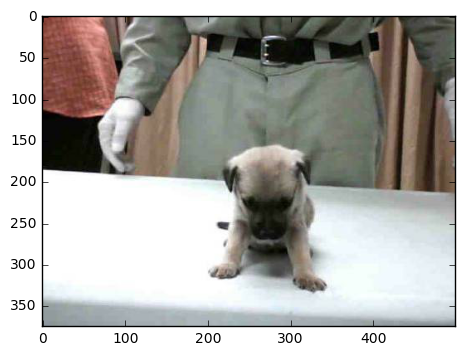

In [24]:
from matplotlib import pyplot as plt
from PIL import Image

i = np.random.randint(len(isdog))
print 'is dog : {}'.format(isdog[i])
img = Image.open('data/test/unknown/{}.jpg'.format(filenames[i]))
plt.imshow(img)
plt.show()